In [1]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gcsfs
import pyarrow.feather as feather
from motif_utils import *
import netsci.metrics.motifs as nsm
import json

## Loading the graph

In [2]:
DATASET = 'fafb_783'
REGION = 'central_complex'
NETWORK = f'{DATASET}_{REGION}'

SYN_LOCAL_PATH = f'data/{NETWORK}/synapses.feather'
GCS_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_synapses.feather'
META_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_meta.feather'

LOAD_FLYVIS = True
NETWORK = 'cell_type'
FLY_VIS_PATH = f'data/flyvis_data//flyvis_cell_type_connectivity.csv'


if not LOAD_FLYVIS:
    print('Network Name:', NETWORK)

    if os.path.exists(SYN_LOCAL_PATH):
        print(f'Loading from local: {SYN_LOCAL_PATH}')
        synapses_df = pd.read_feather(SYN_LOCAL_PATH)
    else:
        print(f'Loading from GCS: {GCS_PATH}')
        import gcsfs
        gcs = gcsfs.GCSFileSystem(token='google_default')
        import pyarrow.feather as feather
        with gcs.open(GCS_PATH.replace('gs://', ''), 'rb') as f:
            synapses_df = feather.read_feather(f)
        with gcs.open(META_PATH.replace('gs://', ''), 'rb') as f:
            meta_df = feather.read_feather(f)

    # Add edges (multiple synapses between same neurons become edge weight)
    edge_counts = synapses_df.groupby(['pre', 'post']).size().reset_index(name='weight')

else:
    print(f'Loading from FlyVis data: {FLY_VIS_PATH}')
    synapses_df = pd.read_csv(FLY_VIS_PATH)
    print(f'  Columns: {list(synapses_df.columns)}')
    assert not synapses_df.duplicated(subset=['source_type', 'target_type']).any(), "Duplicates found! You actually DO need groupby."
    edge_counts = synapses_df.rename(columns={
        'source_type': 'pre',
        'target_type': 'post',
        'syn_count': 'weight'
    })


print(f'✓ Loaded {len(synapses_df):,} synapses')
synapses_df.head()

Loading from FlyVis data: data/flyvis_data//flyvis_cell_type_connectivity.csv
  Columns: ['source_type', 'target_type', 'syn_count']
✓ Loaded 604 synapses


,source_type,target_type,syn_count
0,Am,C2,721
1,Am,C3,721
2,Am,L1,721
3,Am,L2,721
4,Am,L3,721


In [3]:
print(f'✓ Loaded {len(synapses_df):,} synapses')
G_connectome = nx.DiGraph()

for _, row in tqdm(edge_counts.iterrows()):
    if (row['pre'] != row['post']):  # Exclude self-connections
        G_connectome.add_edge(row['pre'], row['post'], weight=row['weight'])
    else:
        print(f'Ignoring self-connection for node {row["pre"]}')

print(f'✓ Built connectome graph')
print(f'  Nodes: {G_connectome.number_of_nodes():,}')
print(f'  Edges: {G_connectome.number_of_edges():,}')
print(f'  Density: {nx.density(G_connectome):.4f}')

mat_sparse = nx.to_scipy_sparse_array(G_connectome)
bin_mat_sparse = mat_sparse.copy()
bin_mat_sparse[bin_mat_sparse > 1] = 1
# bin_mat_sparse.setdiag(0)

# Create mapping between node IDs and matrix indices
node_list = list(G_connectome.nodes())
node_id_to_index = {node_id: idx for idx, node_id in enumerate(node_list)}
index_to_node_id = {idx: node_id for idx, node_id in enumerate(node_list)}

✓ Loaded 604 synapses


604it [00:00, 51924.81it/s]

Ignoring self-connection for node L4
Ignoring self-connection for node L5
Ignoring self-connection for node Lawf2
Ignoring self-connection for node Mi15
Ignoring self-connection for node Mi4
Ignoring self-connection for node T2
Ignoring self-connection for node T4a
Ignoring self-connection for node T4b
Ignoring self-connection for node T4c
Ignoring self-connection for node T4d
Ignoring self-connection for node T5a
Ignoring self-connection for node T5b
Ignoring self-connection for node T5c
Ignoring self-connection for node T5d
Ignoring self-connection for node Tm20
Ignoring self-connection for node Tm3
Ignoring self-connection for node Tm4
Ignoring self-connection for node Tm5a
Ignoring self-connection for node Tm5b
Ignoring self-connection for node TmY18
Ignoring self-connection for node TmY3
Ignoring self-connection for node TmY4
Ignoring self-connection for node TmY9
✓ Built connectome graph
  Nodes: 65
  Edges: 581
  Density: 0.1397


## Basic validation

In [4]:
out_degree = G_connectome.out_degree(index_to_node_id[1])
out_degree_mat = bin_mat_sparse[1, :].sum()
print(out_degree, out_degree_mat)

for node in tqdm(G_connectome.nodes):
    assert G_connectome.out_degree(node) == bin_mat_sparse[node_id_to_index[node], :].sum()
    assert G_connectome.in_degree(node) == bin_mat_sparse[:, node_id_to_index[node]].sum()

14 14


100%|██████████| 65/65 [00:00<00:00, 11542.33it/s]


In [5]:
def stats(conn_mat: np.ndarray):
    print('shape:', conn_mat.shape)
    print(f'total connections: {np.sum(conn_mat)}')
    print('total number of elements in the connectivity matrix (N^2):', conn_mat.size)
    print(f"Non-zero elements: {np.count_nonzero(conn_mat)}")
    print(f"Percentage of non-zero elements: {np.count_nonzero(conn_mat) / conn_mat.size * 100:.2f}%")
    max_post_idx, max_pre_idx = np.unravel_index(conn_mat.argmax(), conn_mat.shape)
    print(f'Max synapses between a single pair of neurons: {conn_mat[max_post_idx, max_pre_idx]} (from {max_pre_idx} to {max_post_idx})')

stats(mat_sparse.toarray())
print()
stats(bin_mat_sparse.toarray())

shape: (65, 65)
total connections: 1406253
total number of elements in the connectivity matrix (N^2): 4225
Non-zero elements: 581
Percentage of non-zero elements: 13.75%
Max synapses between a single pair of neurons: 21021 (from 60 to 25)

shape: (65, 65)
total connections: 581
total number of elements in the connectivity matrix (N^2): 4225
Non-zero elements: 581
Percentage of non-zero elements: 13.75%
Max synapses between a single pair of neurons: 1 (from 1 to 0)


## Extraction

In [6]:
netsci_motif_keys = [12, 36, 6, 38, 14, 74, 98, 78, 102, 46, 108, 110, 238]

if LOAD_FLYVIS:
    output_dir = f'data/flyvis_data/{NETWORK}/motifs'
    os.makedirs(output_dir, exist_ok=True)
else:
    output_dir = f'data/{NETWORK}/motifs'
os.makedirs(output_dir, exist_ok=True)
fsl_full_path = f'{output_dir}/participation_nodes.h5'
ex_data_path = f'{output_dir}/ex_data.h5'


if os.path.exists(f'{output_dir}/binary_fsl.json'):
    print('Loading pre-calculated motifs...')
    network_fsl = json.load(open(f'{output_dir}/binary_fsl.json'))
    network_fsl = {int(k): v for k, v in network_fsl.items()}
else:
    print('Calculating motifs...')
    n_reals, participating_nodes = nsm.motifs(bin_mat_sparse.toarray(), algorithm='louzoun', participation=True)
    n_reals = n_reals[3:]
    participating_nodes = participating_nodes[3:]

    network_fsl = {netsci_motif_keys[i]: amount for (i, amount) in enumerate(n_reals)}
    fsl_fully_mapped = {netsci_motif_keys[i]: nodes for (i, nodes) in enumerate(participating_nodes)}

    with open(f'{output_dir}/binary_fsl.json', 'w') as f:
        json.dump({k: int(v) for k, v in network_fsl.items()}, f)

    save_motif_participation_nodes_h5(fsl_fully_mapped, fsl_full_path)

Loading pre-calculated motifs...


In [7]:
motif_ids = sorted(list(triplets_names.keys()))
motifs = {motif_id: create_base_motif(motif_id) for motif_id in motif_ids}
for motif_id in motif_ids:
    motifs[motif_id].n_real = network_fsl.get(motif_id, 0)

fsl_nodes = {}

In [8]:
def convert_part_nodes_to_sub_graphs(motif, participating_nodes: list):
    fsl_fully_mapped = []
    for i, sub_graphs in enumerate(tqdm(participating_nodes)):
        nodes = list(sub_graphs)
        graph_nodes = [index_to_node_id[n] for n in nodes]
        sub_graph_edges = nx.induced_subgraph(G_connectome, graph_nodes).edges
        fsl_fully_mapped.append(tuple(sub_graph_edges))
    motif.sub_graphs = fsl_fully_mapped


def populate_motif(motif: Motif, participating_nodes: list):
    print('converting nodes to sub graphs...')
    convert_part_nodes_to_sub_graphs(motif, participating_nodes)
    print('sorting node roles...')
    motif.node_roles = sort_node_roles_in_sub_graph(appearances=motif.sub_graphs, neuron_names=node_id_to_index, motif=motif)


# def get_motif_roles_freq_csv(motif):
#     all_nodes_data = []
#     for node in tqdm(neuron_names):
#         node_data_dict = {}
#         for role in motif.node_roles.keys():
#             node_data_dict[f'{motif.id}_{role}'] = motif.node_roles[role].get(node, 0)
#         all_nodes_data.append(node_data_dict)

#     node_roles_df = pd.DataFrame(all_nodes_data)
#     node_roles_df.to_csv(f'{output_dir}/motif_{motif.id}_roles_freq.csv', index=True)


def get_motif_subgraphs_csv(motif):
    all_subgraphs_data = []
    for sub_graph in tqdm(motif.sub_graphs):
        all_subgraphs_data.append(get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern))

    sub_graphs_df = pd.DataFrame(all_subgraphs_data)
    sub_graphs_df.to_csv(f'{output_dir}/motif_{motif.id}_subgraphs.csv', index=True)


def get_motif_edges_csv(motif):
    all_edges_data = []
    for nodes in tqdm(fsl_nodes[motif.id]):
        neurons = [index_to_node_id[idx] for idx in nodes]
        subgraph = nx.induced_subgraph(G_connectome, neurons)
        for edge in subgraph.edges:
            edge_data = {
                'source': edge[0],
                'target': edge[1]
            }
            all_edges_data.append(edge_data)

    edges_df = pd.DataFrame(all_edges_data)
    edges_df.drop_duplicates(inplace=True)
    edges_df.to_csv(f'{output_dir}/motif_{motif.id}_edges.csv', index=True)

In [9]:
for motif_id in [38]: #[6,78,46,98,78,38]:
    fsl_nodes[motif_id] = load_motif_participation_nodes_h5(fsl_full_path, motif_id)

    assert len(fsl_nodes[motif_id]) == motifs[motif_id].n_real
    print(motifs[motif_id].name)
    print(len(fsl_nodes[motif_id]))

    motif = motifs[motif_id]
    loaded_sg = None
    if os.path.isfile(ex_data_path):
        print('Loading existing motif data...')
        loaded_sg, loaded_roles = load_motif_data(motif.id, ex_data_path)
        if loaded_sg:
            motif.node_roles = loaded_roles
            motif.sub_graphs = loaded_sg
    if not loaded_sg or not os.path.isfile(ex_data_path):
        populate_motif(motif, fsl_nodes[motif_id])
        # populate_motif_data(motif.sub_graphs, motif.node_roles, motif.id, ex_data_path)

    # get_motif_roles_freq_csv(motif)
    # get_motif_subgraphs_csv(motif)
    # get_motif_edges_csv(motif)

feed forward
310
converting nodes to sub graphs...


100%|██████████| 310/310 [00:00<00:00, 28577.20it/s]

sorting node roles...


### exploration

In [10]:
triplets = fsl_nodes[38][0:1]
neurons_set = set()
for triplet in triplets:
    triplet_neuron = [index_to_node_id[idx] for idx in triplet]
    print(triplet_neuron)
    neurons_set.update(triplet_neuron)
neurons_set

['Am', 'L2', 'L1']


{'Am', 'L1', 'L2'}

In [11]:
subgraph = nx.induced_subgraph(G_connectome, neurons_set)

print(subgraph.edges)
print(f"Nodes in subgraph: {subgraph.nodes()}")
print("Edges in subgraph:")
if subgraph.number_of_edges() == 0:
    print(" No edges found between these specific nodes.")
else:
    for u, v, data in subgraph.edges(data=True):
        print(f"  {u} -> {v}, weight: {data.get('weight')}")

[('Am', 'L1'), ('Am', 'L2'), ('L2', 'L1')]
Nodes in subgraph: ['L1', 'Am', 'L2']
Edges in subgraph:
  Am -> L1, weight: 721
  Am -> L2, weight: 721
  L2 -> L1, weight: 721


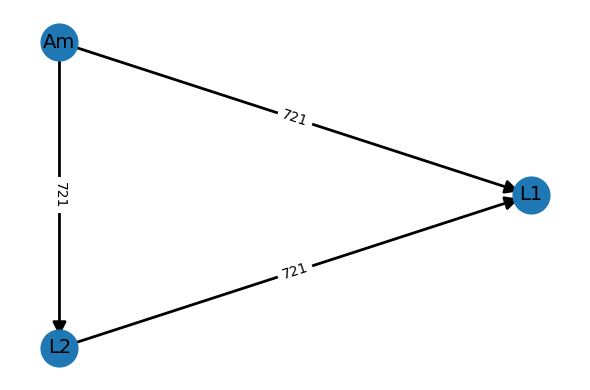

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# 2. Plotting
plt.figure(figsize=(6, 4))
pos = nx.circular_layout(subgraph)  # Layout for consistent positioning

# Draw the nodes and edges
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color='C0')
nx.draw_networkx_edges(subgraph, pos, width=2, arrowsize=20)
nx.draw_networkx_labels(subgraph, pos, font_size=14, font_family="sans-serif")

# FIX: Get just the 'weight' value and explicitly pass it to the function
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.axis('off')
plt.tight_layout()
plt.show()

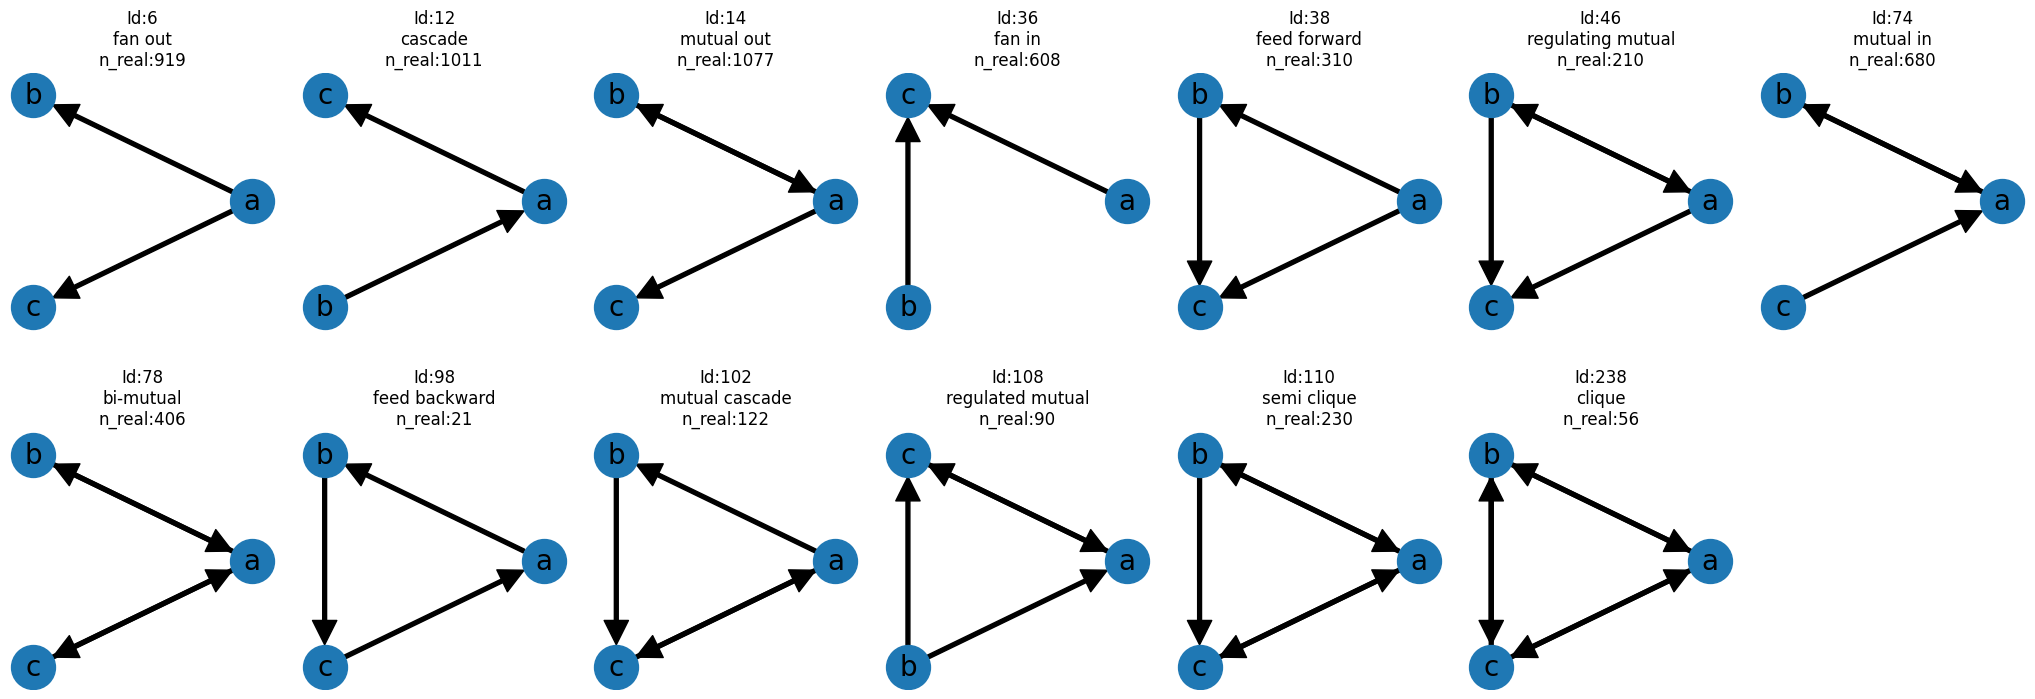

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(26, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.1)

axs = axs.flatten()
for i, motif in enumerate(motifs.values()):
    n_real = motif.n_real
    draw_motif_single(motif, title=f'Id:{motif.id}\n{motif.name}\nn_real:{n_real}', ax=axs[i])

fig.delaxes(axs[-1])
plt.show()

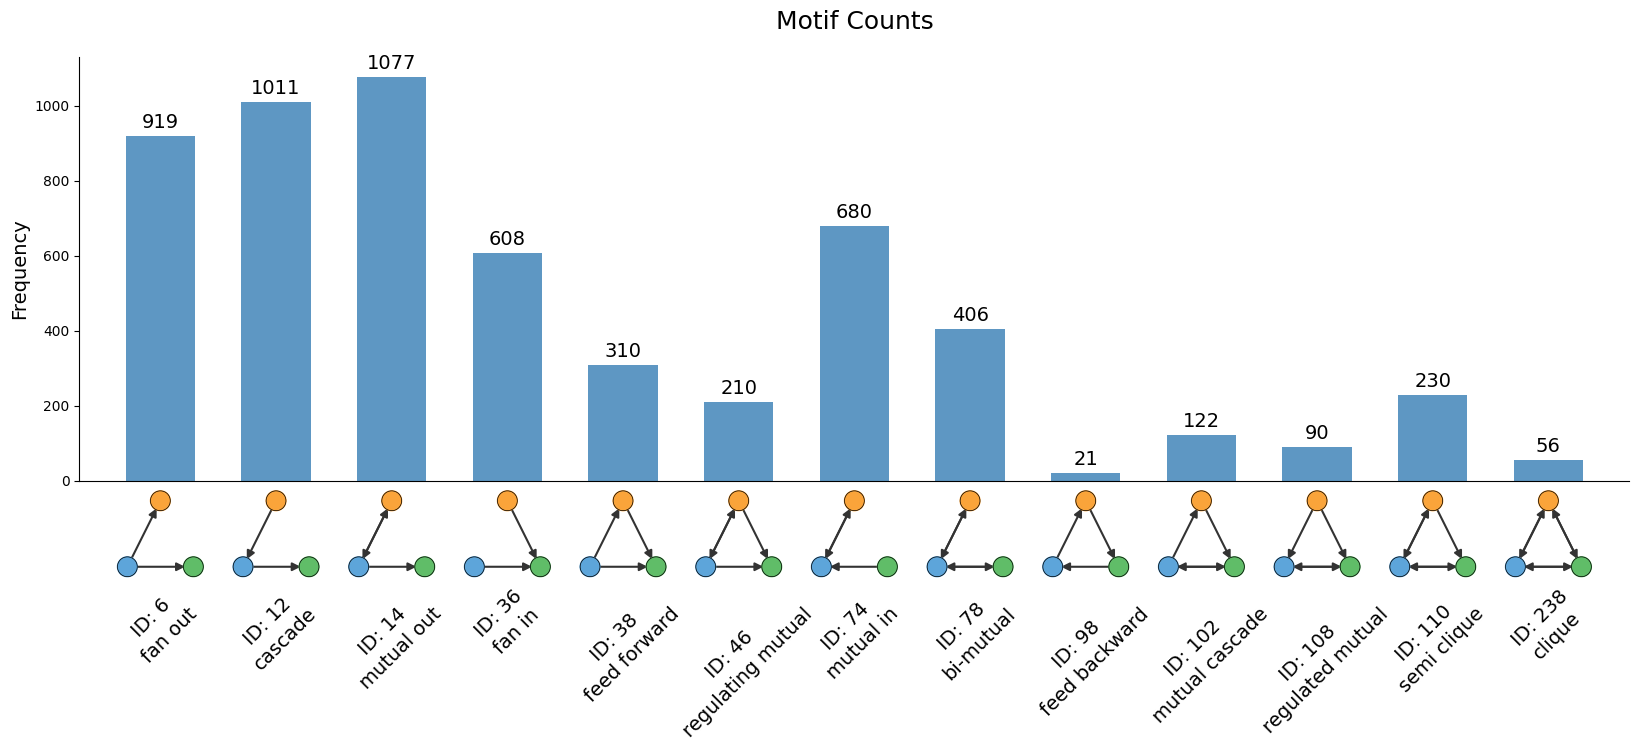

In [14]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch
import networkx as nx

# --- 1. GEOMETRIC DRAWER (Clean triangles) ---
def draw_motif_geometric(motif, ax):
    """
    Draws the motif as a clean geometric triangle (Bottom-Left, Top, Bottom-Right).
    """
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Triangle Coordinates: (x, y)
    # 0: Bottom-Left, 1: Top, 2: Bottom-Right
    coords = {
        0: (0.2, 0.2), 
        1: (0.5, 0.8), 
        2: (0.8, 0.2)
    }
    
    # Colors: Blue, Orange, Green (matching your ideal image)
    colors = {0: '#5da5da', 1: '#faa43a', 2: '#60bd68'}

    # Get edges from the motif object
    # Assuming motif.role_pattern is a NetworkX graph
    G = nx.DiGraph(motif.role_pattern)
    node_list = sorted(list(G.nodes())) # Ensure consistent node mapping (a,b,c -> 0,1,2)
    node_map = {n: i for i, n in enumerate(node_list)}
    
    # Draw Arrows (Edges)
    for u, v in G.edges():
        start = coords[node_map[u]]
        end = coords[node_map[v]]
        
        arrow = FancyArrowPatch(
            posA=start, posB=end,
            arrowstyle='-|>',
            mutation_scale=12,  # Arrow head size
            color='#333333',
            linewidth=1.5,
            shrinkA=6, shrinkB=6 # Gap between arrow and node
        )
        ax.add_patch(arrow)

    # Draw Nodes
    for i, (x, y) in coords.items():
        # zorder=10 ensures nodes are drawn on top of the arrows
        circle = plt.Circle((x, y), 0.09, color=colors[i], zorder=10)
        ax.add_patch(circle)
        
        # Optional: Thin black border around nodes
        border = plt.Circle((x, y), 0.09, color='black', fill=False, lw=0.5, zorder=11)
        ax.add_patch(border)


# --- 2. MAIN PLOT ---

# Setup Data
motif_list = list(motifs.values())
counts = [m.n_real for m in motif_list]
x_coords = range(len(motif_list))

# Create Figure (Wide enough to fit everything)
fig, ax = plt.subplots(figsize=(20, 8))

# Draw Bars
bars = ax.bar(x_coords, counts, width=0.6, color='#4c8cbd', alpha=0.9)

# Format Main Axis
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Motif Counts', fontsize=18, pad=20)
ax.set_xticks([]) # Hide default x-axis ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-0.7, len(motif_list) - 0.3)

# Add Count Labels on Bars
max_val = max(counts) if counts else 1
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max_val*0.01),
            f'{int(height)}', ha='center', va='bottom', fontsize=14)


# --- 3. PLACE MOTIFS BELOW AXIS ---

# Create Blended Transform
# X matches Data (0, 1, 2...), Y matches Axes (0.0 to 1.0)
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

for i, motif in enumerate(motif_list):
    
    # 1. Create Inset Axis for the Triangle
    # bbox_to_anchor=(x, y, w, h)
    # x = i (center of bar)
    # y = -0.12 (The vertical position - adjust this to move motifs up/down)
    # width/height = 1 (dummy units, real size set by width=1.1 below)
    
    ax_inset = inset_axes(ax,
                          width=1.1, height=1.1, # Physical size in inches
                          loc='center', 
                          bbox_to_anchor=(i-0.5, -0.625, 1, 1), 
                          bbox_transform=trans,
                          borderpad=0)
    
    # Draw the clean geometric motif
    draw_motif_geometric(motif, ax_inset)
    
    # 2. Add Text Labels (ID and Name)
    # We place this text relative to the bar position 'i'
    # y = -0.24 puts it below the motif inset
    label_text = f"ID: {motif.id}\n{motif.name}"
    ax.text(i, -0.25, label_text, transform=trans, rotation=45,
            ha='center', va='top', fontsize=14, linespacing=1.4)

# Adjust bottom margin to make space for the motifs and text
plt.subplots_adjust(bottom=0.35)
plt.show()